This file is designed as a standalone to get a feel for the effect of multiplicative noise in oscillator problems

In [17]:
import numpy as np
from math import pi
import math 
import matplotlib.pyplot as plt

from numba import jit 
import seaborn as sns

params = {'xtick.labelsize': 18, 'ytick.labelsize': 18,
              'legend.fontsize': 16, 'axes.labelsize': 18,
              'axes.titlesize': 18,  'font.size': 18, 
              'legend.handlelength': 2}

In [ ]:
@jit(nopython=True)
def f_sin(X, om, lam=0):
    """Drift (deterministic) component"""
    return(om + lam*np.sin(X))

@jit(nopython=True)
def g(X, D):
    """Diffusion component"""
    return(D * np.sin(X))

@jit(nopython=True)
def g_der(X, D):
    """Derivative of g for Stratonovich calculus"""
    return(D * np.cos(X))

In [ ]:
def osc_mod(x):
    """Makes series periodic"""
    
    phi = [s%(2*pi) for s in x]

    for k in range(len(phi)):
        if(phi[k] >= pi):
            phi[k] = phi[k] -2*pi

    return(phi)

def tlabels(ax):
    """Label time plot"""
    
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels([r'$-\pi$', r'0', r'$\pi$'])
    ax.set_ylabel(r'$\theta$')
    ax.set_xlabel(r'$t$')

    ax.tick_params(bottom=True, left=True)
    ax.tick_params(direction="in", length=4, width=1, grid_alpha=0.5)

def labels(ax, ylim=None):
    """Label prob density plot"""

    ax.set_xticks([-np.pi, 0, np.pi])
    ax.set_xticklabels([r'$-\pi$', r'0', r'$\pi$'])
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$P(\theta)$')

    ax.tick_params(bottom=True, left=True)
    ax.tick_params(direction="in", length=4, width=1, grid_alpha=0.5)

    if ylim: ax.set_ylim([ylim[0],ylim[1]])

In [ ]:
@jit(nopython=True) 
def SDE_ev(om, D1, D2, T, f, g, dt=0.001, xinit=10, 
           sig=0, steps=1, meth='ito'):
    """Show evolution of SDE"""

    n_ = int(T / dt)  
    D1_, D2_ = np.sqrt(2*D1), np.sqrt(2*D2)
    sdt = np.sqrt(dt)

    X = xinit
    X_det = xinit
    tl, Xl, Xl_det = [], [], []

    step = int(T/(dt*10000*steps))

    for i in range(n_):
        if meth=='ito':
            dx = dt * f(X, om, lam=sig) + sdt * g(X, D1_) * np.random.randn() + sdt * D2_ * np.random.randn() 
        elif meth=='strat':
            dx = dt * (f(X, om, lam=sig) + 0.5*g_der(X, D1_)*g(X, D1_)) + \
                 sdt * g(X, D1_) * np.random.randn() + sdt * D2_ * np.random.randn()
         
        if math.isnan(dx): continue 
        X += dx 

        X_det += dt * f(X_det, om, lam=sig)

        if i%step==0: 
            X = (X + 2*pi)%(2*pi) 
            if(X >= pi): X -= 2*pi

            X_det = (X_det + 2*pi)%(2*pi) 
            if(X_det >= pi): X_det -= 2*pi

            Xl.append(X)
            Xl_det.append(X_det)
            tl.append(i*dt)

    return(tl, Xl, Xl_det)

@jit(nopython=True)
def stat_den_sde(om, D1, D2, T, f_, g, dt, Nb=300, lim=np.pi, xinit=0.1, start=50000, sig=0, meth='ito'): 
    """Prob. distribution"""

    n_ = int(T / dt)  
    st = start
    Pl = np.zeros(Nb) 
    D1_, D2_ = np.sqrt(2*D1), np.sqrt(2*D2)
    sdt = np.sqrt(dt)
    X = xinit

    xm = -lim       
    del_x = 2*lim/Nb
    x = np.arange(-lim,lim,del_x)
    X = 2*lim*np.random.rand() - lim
    norm = 1/(del_x*(n_-st))

    if meth=='ito':
        for i in range(n_):

            X += dt * f_(X, om, lam=sig) + sdt * g(X, D1_) * np.random.randn() + \
                                    sdt * D2_ * np.random.randn()

            X = (X + 2*lim)%(2*lim) 
            if(X >= lim): X -= 2*lim 

            if math.isnan(X): X = 2*lim*np.random.rand() - lim

            if i > st: 
                k = int(np.floor((X-xm)/del_x))
                Pl[k] += norm 

    if meth=='strat':
        for i in range(n_):

            X += dt * (f_(X, om, lam=sig) + 0.5*g_der(X, D1_)*g(X, D1_)) + \
                 sdt * g(X, D1_) * np.random.randn() + sdt * D2_ * np.random.randn()

            X = (X + 2*lim)%(2*lim) 
            if(X >= lim): X -= 2*lim 

            if math.isnan(X): X = 2*lim*np.random.rand() - lim

            if i > st: 
                k = int(np.floor((X-xm)/del_x))
                Pl[k] += norm 

    return(x, Pl)

The following are simulations of the stochastic Adler equation

$$\Delta \dot{\theta} = \Delta \omega + (\sigma + \sqrt{2D_1}\xi_1(t))\sin \Delta \theta + \sqrt{2D_2}\xi_2(t)$$

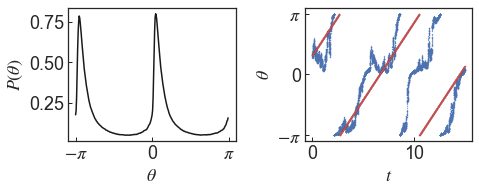

In [43]:
sns.set_theme(style="white", rc=params)
f, (ax, ax2) = plt.subplots(1, 2, figsize=(7, 3))

om, D1, D2, T, sig = 0.8, 2, 0, 10000, 0

x_osc, P_osc = stat_den_sde(om, D1, D2, T, f_sin, g, dt=0.001, lim=np.pi, sig=sig)

ax.plot(x_osc, P_osc, 'k', label='Sin.')

labels(ax)

#-----

dt = 0.000001
T = 15
    
tl, xl, xl_det = SDE_ev(om, D1, 0, T, f_sin, g, dt, xinit=1, sig=sig)

ax2.plot(tl, xl, '.', markersize=0.6)
ax2.plot(tl, xl_det, 'r.', markersize=0.2)
tlabels(ax2)

f.tight_layout()

#f.savefig('/Users/tphillips/ex_plot.png', bbox_inches='tight', format='png', dpi=120)

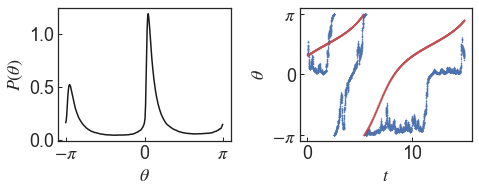

In [ ]:
f, (ax, ax2) = plt.subplots(1, 2, figsize=(7, 3))

om, D1, D2, T, sig = 0.8, 2, 0, 10000, -0.5

x_osc, P_osc = stat_den_sde(om, D1, D2, T, f_sin, g, dt=0.001, lim=np.pi, sig=sig)

ax.plot(x_osc, P_osc, 'k', label='Sin.')

labels(ax)

#-----

dt = 0.000001
T = 15
    
tl, xl, xl_det = SDE_ev(om, D1, 0, T, f_sin, g, dt, xinit=1, sig=sig)

ax2.plot(tl, xl, '.', markersize=0.6)
ax2.plot(tl, xl_det, 'r.', markersize=0.2)
tlabels(ax2)

f.tight_layout()

#f.savefig('/Users/tphillips/ex_plot_2.png', bbox_inches='tight', format='png', dpi=120)